<a href="https://colab.research.google.com/github/im-vne/Snakes-or-No-Snakes/blob/main/2023_08_16_time_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model building and evaluation

This notebook contains the main two methods: CNN and logistic regression. For side analyses see their specific notebook.

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import os # work with system
import cv2 # work with images
import numpy as np # arrays and numerical analysis
import matplotlib.pyplot as plt # for data plots

import sklearn.linear_model # linear models
from sklearn.model_selection import train_test_split # data splitting
from sklearn import metrics # model evaluation
import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import random # for random sampling

### set working directory in data folder
os.chdir("drive/Shareddrives/Capstone 2023/Data/MicrosoftSnakeAlgorithmProject")

In [3]:
tf.config.list_physical_devices('GPU')

[]

In [4]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [5]:
def resample_classes(files, labels, seed = 1):

  '''
  files and labels should both be np arrays
  '''

  # set seed for reproducibility (and possibly error computation)
  random.seed(seed)
  # get number of minority class (snakes)
  n_minority = np.where(labels == 1)[0].shape[0]

  # sample from indices corresponding to empty images
  # downsample_idx should have as many indices as there are snake images
  downsample_idx = np.array(random.sample(list(np.where(labels == 0)[0]), n_minority))
  # final indices should have snakes and downsampled empties
  out_index = np.concatenate((np.where(labels == 1)[0], downsample_idx))

  # subset to resampled data - classes now balanced
  filenames_resampled = files[out_index]
  labels_resampled = labels[out_index]

  print(f'total samples: {out_index.shape[0]}')
  print(f'empty samples: {downsample_idx.shape[0]}')
  print(f'snake samples: {n_minority}')

  return filenames_resampled, labels_resampled

In [6]:
def split_data(files, labels, seed = 27, train = 0.8, test = 0.15):

  '''
  files and labels should both be np arrays
  '''

  # split data: train is 1-test_size and test is test_size*leftover
  # must stratify to ensure roughly equal splits in train, val, test
  # train and test specified, val is 1 - (train + test)
  x_train, x_test, y_train, y_test = train_test_split(
      files, labels, test_size = 1-train, stratify = labels, shuffle = True, random_state = seed)
  x_val, x_test, y_val, y_test = train_test_split(
      x_test, y_test, test_size = test/(1-train), stratify = y_test, shuffle = True, random_state = seed)

  print(f'train: {x_train.shape[0]} ({x_train.shape[0]/labels.shape[0]*100:.2f}%)')
  print(f'val: {x_val.shape[0]} ({x_val.shape[0]/labels.shape[0]*100:.2f}%)')
  print(f'test: {x_test.shape[0]} ({x_test.shape[0]/labels.shape[0]*100:.2f}%)')

  return x_train, y_train, x_val, y_val, x_test, y_test

In [7]:
class data_generator(keras.utils.Sequence) :

  def __init__(self, image_filenames, labels, batch_size, log) :
    self.image_filenames = image_filenames
    self.labels = labels
    self.batch_size = batch_size
    self.log = log

  def __len__(self) :
    return (np.ceil(len(self.image_filenames) / float(self.batch_size))).astype(int)

  def __getitem__(self, idx) :
    batch_x = self.image_filenames[idx * self.batch_size : (idx+1) * self.batch_size]
    batch_y = self.labels[idx * self.batch_size : (idx+1) * self.batch_size]

    # read in and process image (different resizing for logistic regression to reduce trainable parameters)
    if self.log:
      x_list = [cv2.resize(cv2.imread(file_name, cv2.IMREAD_GRAYSCALE), (100, 60), interpolation = cv2.INTER_NEAREST) for file_name in batch_x]
    else:
      x_list = [cv2.resize(cv2.imread(file_name, cv2.IMREAD_GRAYSCALE), (512, 384), interpolation = cv2.INTER_NEAREST) for file_name in batch_x]

    x_arr = np.array(x_list)
    x_arr_reshaped = x_arr.reshape([x_arr.shape[0], x_arr.shape[1], x_arr.shape[2], 1])

    y_arr = np.array(batch_y)
    y_arr_reshaped = y_arr.reshape([x_arr_reshaped.shape[0], 1])

    return x_arr_reshaped, y_arr_reshaped

In [9]:
def create_generators(x_train, y_train, x_val, y_val, x_test, y_test, batch_size = 32, log = False):

  train_generator = data_generator(x_train, y_train, batch_size, log)
  validation_generator = data_generator(x_val, y_val, batch_size, log)
  test_generator = data_generator(x_test, y_test, batch_size, log)

  return train_generator, validation_generator, test_generator


In [8]:
def count_split(data): # much better would be to count 0 and 1 in y_*

  data = list(data)
  snake = [x for x in data if "Snake_Images" in x]
  empty = [x for x in data if "Empty" in x]

  print(f'total: {len(data)}')
  print(f'snake: {len(snake)} ({len(snake)/len(data)*100:.2f}%)')
  print(f'empty: {len(empty)} ({len(empty)/len(data)*100:.2f}%)')

Need to get the correct files subset for the given location and number of snake images

In [42]:
import pandas as pd

df = pd.read_csv("/content/drive/Shareddrives/Capstone 2023/Data/Time_Data/cumulative_organized_Data_Path.csv")
first_column = df.columns[0]
df = df.drop([first_column], axis=1)

empty_img = "MicrosoftSnakeAlgorithmProject/Snake_Images/FL_Snakes/WF8/IMG_7087.JPG"
df = df[df.Path != empty_img]

print(df.head(5))
print(df.tail(5))

   Snake                 Date location camera  \
0      1  2016-03-08 07:36:30      LPS   TSP1   
1      1  2016-03-08 07:37:00      LPS   TSP1   
2      1  2016-03-08 07:37:30      LPS   TSP1   
3      1  2016-03-08 07:38:00      LPS   TSP1   
4      1  2016-03-13 14:46:00      LPS   TSP1   

                                                Path  cumsum_snakes  \
0  /content/drive/Shareddrives/Capstone 2023/Data...              1   
1  /content/drive/Shareddrives/Capstone 2023/Data...              2   
2  /content/drive/Shareddrives/Capstone 2023/Data...              3   
3  /content/drive/Shareddrives/Capstone 2023/Data...              4   
4  /content/drive/Shareddrives/Capstone 2023/Data...              5   

   cumsum_snakes_total  cumsum_snakes_location  cumsum_snakes_camera  
0                    1                       1                     1  
1                    2                       2                     2  
2                    3                       3                   

In [43]:
max_snake = df['cumsum_snakes'].max()

n_snakes =  400
location = 'FL'

df_sub = df[(df.location == location) & (df.cumsum_snakes <= n_snakes)]
print(max_snake)
filenames_arr = df_sub['Path'].to_numpy()
labels_arr = df_sub['Snake'].to_numpy()

df_sub.shape

2129


(2198, 9)

In [44]:
seed = 1
batch_size = 32

filenames_resampled, labels_resampled = resample_classes(filenames_arr, labels_arr, seed = seed)
x_train, y_train, x_val, y_val, x_test, y_test = split_data(filenames_resampled, labels_resampled, train = 0.8, test = 0.15)


print()
count_split(x_train)
count_split(x_val)
count_split(x_test)
print()

# train_generator, validation_generator, test_generator = create_generators(x_train, y_train, x_val, y_val, x_test, y_test, batch_size = batch_size)

total samples: 800
empty samples: 400
snake samples: 400
train: 640 (80.00%)
val: 39 (4.88%)
test: 121 (15.12%)

total: 640
snake: 320 (50.00%)
empty: 320 (50.00%)
total: 39
snake: 19 (48.72%)
empty: 20 (51.28%)
total: 121
snake: 61 (50.41%)
empty: 60 (49.59%)



## CNN

In [15]:
# create data generators
train_generator, validation_generator, test_generator = create_generators(x_train, y_train, x_val, y_val, x_test, y_test, batch_size = batch_size, log = False)

In [16]:
# create model
def build_model():

    model = models.Sequential()
    model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=(384, 512, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(1, activation = 'sigmoid'))

    # compile model with desired features
    model.compile(
        optimizer = "adam", loss = "binary_crossentropy",
        metrics=['accuracy']
    )

    return model

In [17]:
# build the model
cnn_model = build_model()

In [18]:
# view model architecture
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 382, 510, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 191, 255, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 189, 253, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 94, 126, 32)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 92, 124, 64)       18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 46, 62, 64)       0

In [19]:
cnn_fit = cnn_model.fit(
    train_generator,
    steps_per_epoch = int(x_train.shape[0] // batch_size),
    # steps_per_epoch = 10,
    epochs = 3,
    verbose = 1,
    validation_data = validation_generator,
    validation_steps = int(x_val.shape[0] // batch_size)
    # validation_steps = 3
)

Epoch 1/3
20/20 [==============================] - 381s 19s/step - loss: 236.5548 - accuracy: 0.5375 - val_loss: 1.3256 - val_accuracy: 0.4688
Epoch 2/3
20/20 [==============================] - 92s 5s/step - loss: 0.7874 - accuracy: 0.7484 - val_loss: 1.5297 - val_accuracy: 0.7188
Epoch 3/3
20/20 [==============================] - 103s 5s/step - loss: 0.2307 - accuracy: 0.9203 - val_loss: 0.0590 - val_accuracy: 1.0000


In [20]:
model_predict = cnn_model.predict(
    test_generator,
)

4/4 [==============================] - 51s 16s/step


In [21]:
# get class predictions
predictions_cnn = model_predict > 0.5
predictions_cnn = predictions_cnn.reshape(x_test.shape[0])
predictions_cnn.shape[0]

121

In [22]:
set(list(predictions_cnn.reshape(predictions_cnn.shape[0])))

{False, True}

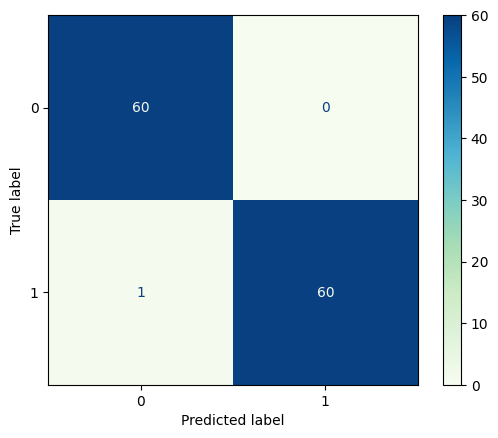

In [23]:
# plot confusion matrix
metrics.ConfusionMatrixDisplay.from_predictions(y_test, predictions_cnn, cmap = "GnBu")

In [24]:
### model evaluation metrics

# (true positive + true negative)/total
accuracy = sklearn.metrics.accuracy_score(y_test, predictions_cnn)
print("accuracy: " + str(accuracy))

# true positive/(true positive + false positive)
precision = sklearn.metrics.precision_score(y_test, predictions_cnn)
print("precision: " + str(precision))

# true positive/(true positive + false negative)
sensitivity = sklearn.metrics.recall_score(y_test, predictions_cnn)
print("sensitivity: " + str(sensitivity))

# true negative/(true negative + false positive)
specificity = sklearn.metrics.recall_score(y_test, predictions_cnn, pos_label = 0)
print("specificity: " + str(specificity))

# 2 * (precision*recall)/(precision+recall)
f1_score = 2*(precision*sensitivity)/(precision+sensitivity)
print("f1_score: " + str(f1_score))

# no false positives means precision and specificity will be 100%

accuracy: 0.9917355371900827
precision: 1.0
sensitivity: 0.9836065573770492
specificity: 1.0
f1_score: 0.9917355371900827


In [26]:
# save model
cnn_model.save('../Snakes-or-No-Snakes/2023-08-16-400-fl')

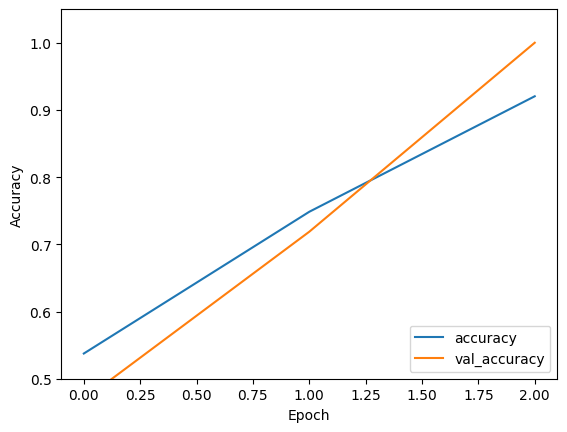

In [25]:
# plot accuracy across epochs
plt.plot(cnn_fit.history['accuracy'], label='accuracy')
plt.plot(cnn_fit.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1.05])
plt.legend(loc='lower right')

In [41]:
###save metrics as dataframe
accuracy
metrics = pd.DataFrame({'Snake Amount':[n_snakes],'Accuracy':[accuracy],'Precision':[precision], 'Sensitivity':[sensitivity],'Specificity':[specificity], 'F1 Score':[f1_score]})
metrics

##intial save of dataset
#path = '/content/drive/Shareddrives/Capstone 2023/Data/model_metrics.csv'
#with open(path, 'w', encoding = 'utf-8-sig') as f:
#  metrics.to_csv(f)


#import dataset
metrics_data = pd.read_csv("/content/drive/Shareddrives/Capstone 2023/Data/model_metrics.csv")

#remove first columnn
first_column = metrics_data.columns[0]
metrics_data = metrics_data.drop([first_column], axis=1)

metrics_data
##append new metrics
metrics_data.loc[len(metrics_data.index)] = []

,Snake Amount,Accuracy,Precision,Sensitivity,Specificity,F1 Score
0,400,0.991736,1.0,0.983607,1.0,0.991736


Standardized test

In [45]:
#####
# get standardized testing data
log = False
#get observations after 1200
test = df[(df.location == location) & (df.cumsum_snakes > n_snakes)]
#get filenames and labels for observations after 1200
filenames_arr_test = test['Path'].to_numpy()
labels_arr_test = test['Snake'].to_numpy()


xtest = filenames_arr_test
ytest =  labels_arr_test



model_predict = cnn_model.predict(
    data_generator(xtest, ytest, batch_size, log)
)

308/308 [==============================] - 5300s 17s/step


In [46]:
##predict
# get class predictions
predictions_cnn = model_predict > 0.5
predictions_cnn = predictions_cnn.reshape(x_test.shape[0])
predictions_cnn.shape[0]

ValueError: ignored

In [ ]:
set(list(predictions_cnn.reshape(predictions_cnn.shape[0])))

{False, True}

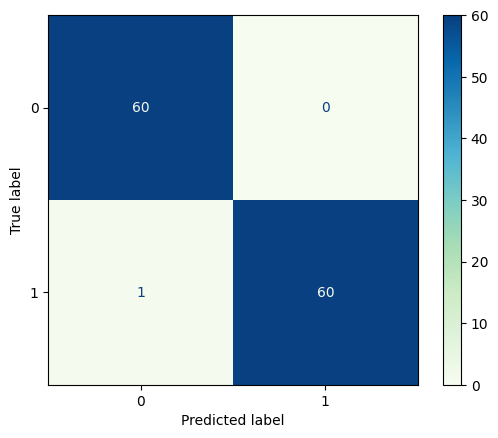

In [ ]:
# plot confusion matrix
metrics.ConfusionMatrixDisplay.from_predictions(y_test, predictions_cnn, cmap = "GnBu")

In [ ]:
### model evaluation metrics

# (true positive + true negative)/total
accuracy = sklearn.metrics.accuracy_score(y_test, predictions_cnn)
print("accuracy: " + str(accuracy))

# true positive/(true positive + false positive)
precision = sklearn.metrics.precision_score(y_test, predictions_cnn)
print("precision: " + str(precision))

# true positive/(true positive + false negative)
sensitivity = sklearn.metrics.recall_score(y_test, predictions_cnn)
print("sensitivity: " + str(sensitivity))

# true negative/(true negative + false positive)
specificity = sklearn.metrics.recall_score(y_test, predictions_cnn, pos_label = 0)
print("specificity: " + str(specificity))

# 2 * (precision*recall)/(precision+recall)
f1_score = 2*(precision*sensitivity)/(precision+sensitivity)
print("f1_score: " + str(f1_score))

# no false positives means precision and specificity will be 100%

accuracy: 0.9917355371900827
precision: 1.0
sensitivity: 0.9836065573770492
specificity: 1.0
f1_score: 0.9917355371900827


In [ ]:
# save model
cnn_model.save('../Snakes-or-No-Snakes/2023-08-16-400-fl-std')

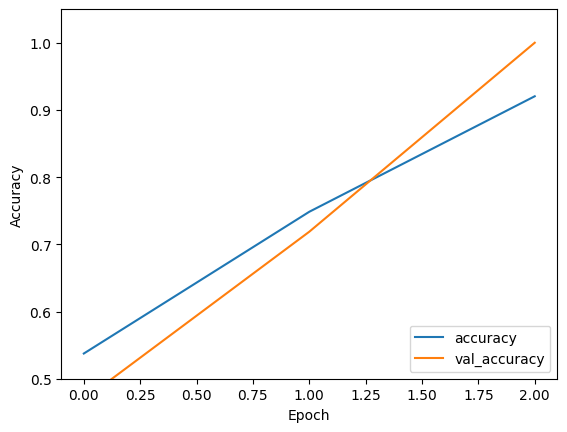

In [ ]:
# plot accuracy across epochs
plt.plot(cnn_fit.history['accuracy'], label='accuracy')
plt.plot(cnn_fit.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1.05])
plt.legend(loc='lower right')

In [ ]:
###save metrics as dataframe
accuracy
standard_metrics = pd.DataFrame({'Snake Amount':[n_snakes],'Accuracy':[accuracy],'Precision':[precision], 'Sensitivity':[sensitivity],'Specificity':[specificity], 'F1 Score':[f1_score]})
standard_metrics

##intial save of dataset
#path = '/content/drive/Shareddrives/Capstone 2023/Data/model_metrics.csv'
#with open(path, 'w', encoding = 'utf-8-sig') as f:
#  metrics.to_csv(f)


#import dataset
standard_metrics_data = pd.read_csv("/content/drive/Shareddrives/Capstone 2023/Data/model_metrics.csv")

#remove first columnn
first_column = standard_metrics_data.columns[0]
metrics_data = standard_metrics_data.drop([first_column], axis=1)

standard_metrics_data
##append new metrics